## Project 2: Titanic Competition with deep learning

In this notebook we build and train a deep learning model without using a high-level API library to solve Kaggle's [Titanic](https://www.kaggle.com/competitions/titanic/) competition!

In [ ]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
creds = '{"username":"zhukevin2020","key":"dc4317bf07a05827b700557e31aca195"}'

In [ ]:
from pathlib import Path

cred_path = Path('~/.kaggle/kaggle.json').expanduser()
if not cred_path.exists():
    cred_path.parent.mkdir(exist_ok=True)
    cred_path.write_text(creds)
    cred_path.chmod(0o600)

In [ ]:
path = Path('titanic')

In [ ]:
if not path.exists():
    import zipfile,kaggle
    kaggle.api.competition_download_cli(str(path))
    zipfile.ZipFile(f'{path}.zip').extractall(path)

100%|██████████| 34.1k/34.1k [00:00<00:00, 3.05MB/s]

In [ ]:
!ls {path}


gender_submission.csv  test.csv  train.csv


In [ ]:
import torch, numpy as np, pandas as pd
np.set_printoptions(linewidth=140)
torch.set_printoptions(linewidth=140, sci_mode=False, edgeitems=7)
pd.set_option('display.width', 140)

## Cleaning the data

We will use *pandas* to do our data operations. We store the data in a `DataFrame`.

In [ ]:
df = pd.read_csv(path/'train.csv')
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


### Remove missing values

In order to use a neural net, each entry must be numerical. First, let's get rid of missing values, i.e `NaN` values.

In [ ]:
# Locate which columns contain `NaN` values. 
# Pandas' `isna()` function returns `True` (which is treated as `1` when used as a number) for `NaN` values,
# so we can just add them up for each column (by default Pandas sums over columns)

df.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

Let's replace the NaNs with, say, (the "*mode*").

In [ ]:
# Use the `mode` function. One caveat is that in the case of ties, it returns more than one row. We can grab the first row with `iloc[0]`:
modes = df.mode().iloc[0]
modes

PassengerId                      1
Survived                       0.0
Pclass                         3.0
Name           Abbing, Mr. Anthony
Sex                           male
Age                           24.0
SibSp                          0.0
Parch                          0.0
Ticket                        1601
Fare                          8.05
Cabin                      B96 B98
Embarked                         S
Name: 0, dtype: object

In [ ]:
# Now that we've got the mode of each column, we can use `fillna` to replace the missing values with the mode of each column. 
# We'll do it "in place" -- meaning that we'll change the dataframe itself, rather than returning a new one.

df.fillna(modes, inplace=True)

We can now check there's no missing values left:

In [ ]:
df.isna().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
dtype: int64

### Feature Engineering

We can get a quick summary of all the numeric columns in the dataset:

In [ ]:
import numpy as np

df.describe(include=(np.number))

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,28.566970,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,13.199572,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,22.000000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,24.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,35.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


What do you notice about values in the Fare column? We can see the issue more clearly visually by looking at a histogram.

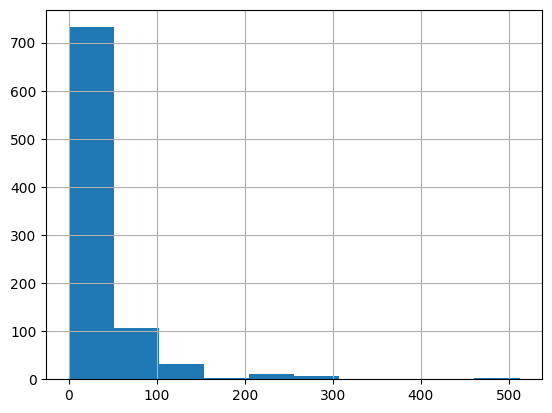

In [ ]:
# We can create a histogram for a given column with .hist()

df['Fare'].hist();

To fix this, we can take the logarithm. Note, however, that there are zeros in the `Fare` column, and `log(0)` is infinite -- to fix this, we'll simply add `1` to all values first:

In [ ]:
df['LogFare'] = np.log(df['Fare']+1)

The histogram now shows a more even distribution of values without the long tail:

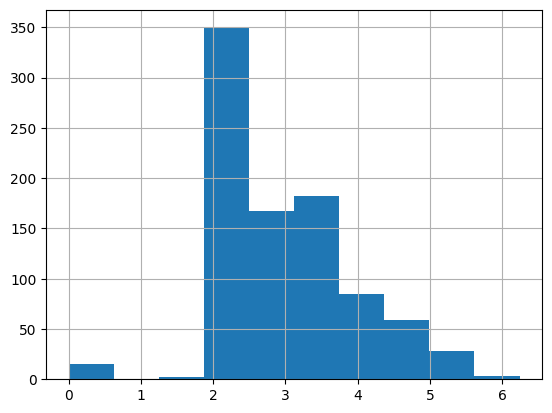

In [ ]:
df['LogFare'].hist();

### Transforming Categorical Variables

It looks from the `describe()` output like `Pclass` contains just 3 values

In [ ]:
pclasses = sorted(df.Pclass.unique())
pclasses

[1, 2, 3]

Here's how we get a quick summary of all the non-numeric columns in the dataset:

In [ ]:
df.describe(include=[object])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,891,891
unique,891,2,681,147,3
top,"Braund, Mr. Owen Harris",male,347082,B96 B98,S
freq,1,577,7,691,646


We can't multiply strings like `male` or `S` by coefficients, so we need to replace those with numbers.

We do that by creating new columns containing *dummy variables*. A dummy variable is a column that contains a `1` where a particular column contains a particular value, or a `0` otherwise. For instance, we could create a dummy variable for `Sex='male'`, which would be a new column containing `1` for rows where `Sex` is `'male'`, and 0 for rows where it isn't.


In [ ]:
# Pandas can create these automatically using `get_dummies`, which also remove the original columns.
# We'll create dummy variables for `Pclass`, even although it's numeric, since the numbers `1`, `2`, and `3` correspond to first, second, and third class cabins - 
# - not to counts or measures that make sense to multiply by.
#  We'll also create dummies for `Sex` and `Embarked` since we'll want to use those as predictors in our model. 
# On the other hand, `Cabin`, `Name`, and `Ticket` have too many unique values for it to make sense creating dummy variables for them, so we can just disregard them.

df = pd.get_dummies(df, columns=['Sex','Pclass','Embarked'])
df.columns

Index(['PassengerId', 'Survived', 'Name', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'LogFare', 'Sex_female', 'Sex_male',
       'Pclass_1', 'Pclass_2', 'Pclass_3', 'Embarked_C', 'Embarked_Q', 'Embarked_S'],
      dtype='object')

We can see that 5 columns have been added to the end -- one for each of the possible values of each of the three columns we requested, and that those three requested columns have been removed.

Here's what the first few rows of those newly added columns look like:

In [ ]:
added_cols = ['Sex_male', 'Sex_female', 'Pclass_1', 'Pclass_2', 'Pclass_3', 'Embarked_C', 'Embarked_Q', 'Embarked_S']
df[added_cols].head()

,Sex_male,Sex_female,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S
0,1,0,0,0,1,0,0,1
1,0,1,1,0,0,1,0,0
2,0,1,0,0,1,0,0,1
3,0,1,1,0,0,0,0,1
4,1,0,0,0,1,0,0,1


Now we can create our independent (predictors) and dependent (target) variables. They both need to be PyTorch tensors. Our dependent variable is `Survived`:

In [ ]:
from torch import tensor

t_dep = tensor(df.Survived)

Our independent variables are all the continuous variables of interest plus all the dummy variables we just created:

In [ ]:
indep_cols = ['Age', 'SibSp', 'Parch', 'LogFare'] + added_cols

t_indep = tensor(df[indep_cols].values, dtype=torch.float)
t_indep

tensor([[22.0000,  1.0000,  0.0000,  2.1102,  1.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000],
        [38.0000,  1.0000,  0.0000,  4.2806,  0.0000,  1.0000,  1.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000],
        [26.0000,  0.0000,  0.0000,  2.1889,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000],
        [35.0000,  1.0000,  0.0000,  3.9908,  0.0000,  1.0000,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  1.0000],
        [35.0000,  0.0000,  0.0000,  2.2028,  1.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000],
        [24.0000,  0.0000,  0.0000,  2.2469,  1.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  1.0000,  0.0000],
        [54.0000,  0.0000,  0.0000,  3.9677,  1.0000,  0.0000,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  1.0000],
        ...,
        [25.0000,  0.0000,  0.0000,  2.0857,  1.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000],
        [39.0000,  0.0000,  5.0000,  3.4054

Here's the number of rows and columns we have for our independent variables:

In [ ]:
t_indep.shape

torch.Size([891, 12])

## Setting up a linear model

Now that we've got a matrix of independent variables and a dependent variable vector, we can work on calculating our predictions and our loss. In this section, we're going to manually do a single step of calculating predictions and loss for every row of our data.

Our first model will be a simple linear model. We'll need a coefficient for each column in `t_indep`. We'll pick random numbers in the range `(-0.5,0.5)`, and set our manual seed so that my explanations in the prose in this notebook will be consistent with what you see when you run it.

In [ ]:
torch.manual_seed(442)

n_coeff = t_indep.shape[1]
coeffs = torch.rand(n_coeff)-0.5
coeffs

tensor([-0.4629,  0.1386,  0.2409, -0.2262, -0.2632, -0.3147,  0.4876,  0.3136,  0.2799, -0.4392,  0.2103,  0.3625])

Our predictions will be calculated by multiplying each row by the coefficients, and adding them up. One interesting point here is that we don't need a separate constant term (also known as a "bias" or "intercept" term), or a column of all `1`s to give the same effect has having a constant term. That's because our dummy variables already cover the entire dataset -- e.g. there's a column for "male" and a column for "female", and everyone in the dataset is in exactly one of these; therefore, we don't need a separate intercept term to cover rows that aren't otherwise part of a column.

Here's what the multiplication looks like:

In [ ]:
t_indep*coeffs

tensor([[-10.1838,   0.1386,   0.0000,  -0.4772,  -0.2632,  -0.0000,   0.0000,   0.0000,   0.2799,  -0.0000,   0.0000,   0.3625],
        [-17.5902,   0.1386,   0.0000,  -0.9681,  -0.0000,  -0.3147,   0.4876,   0.0000,   0.0000,  -0.4392,   0.0000,   0.0000],
        [-12.0354,   0.0000,   0.0000,  -0.4950,  -0.0000,  -0.3147,   0.0000,   0.0000,   0.2799,  -0.0000,   0.0000,   0.3625],
        [-16.2015,   0.1386,   0.0000,  -0.9025,  -0.0000,  -0.3147,   0.4876,   0.0000,   0.0000,  -0.0000,   0.0000,   0.3625],
        [-16.2015,   0.0000,   0.0000,  -0.4982,  -0.2632,  -0.0000,   0.0000,   0.0000,   0.2799,  -0.0000,   0.0000,   0.3625],
        [-11.1096,   0.0000,   0.0000,  -0.5081,  -0.2632,  -0.0000,   0.0000,   0.0000,   0.2799,  -0.0000,   0.2103,   0.0000],
        [-24.9966,   0.0000,   0.0000,  -0.8973,  -0.2632,  -0.0000,   0.4876,   0.0000,   0.0000,  -0.0000,   0.0000,   0.3625],
        ...,
        [-11.5725,   0.0000,   0.0000,  -0.4717,  -0.2632,  -0.0000,   0.0000

We can see we've got a problem here. The sums of each row will be dominated by the first column, which is `Age`, since that's bigger on average than all the others.

Let's make all the columns contain numbers from `0` to `1`, by dividing each column by its `max()`:

In [ ]:
vals,indices = t_indep.max(dim=0)
t_indep = t_indep/vals

As we see, that removes the problem of one column dominating all the others:

In [ ]:
t_indep*coeffs

tensor([[-0.1273,  0.0173,  0.0000, -0.0765, -0.2632, -0.0000,  0.0000,  0.0000,  0.2799, -0.0000,  0.0000,  0.3625],
        [-0.2199,  0.0173,  0.0000, -0.1551, -0.0000, -0.3147,  0.4876,  0.0000,  0.0000, -0.4392,  0.0000,  0.0000],
        [-0.1504,  0.0000,  0.0000, -0.0793, -0.0000, -0.3147,  0.0000,  0.0000,  0.2799, -0.0000,  0.0000,  0.3625],
        [-0.2025,  0.0173,  0.0000, -0.1446, -0.0000, -0.3147,  0.4876,  0.0000,  0.0000, -0.0000,  0.0000,  0.3625],
        [-0.2025,  0.0000,  0.0000, -0.0798, -0.2632, -0.0000,  0.0000,  0.0000,  0.2799, -0.0000,  0.0000,  0.3625],
        [-0.1389,  0.0000,  0.0000, -0.0814, -0.2632, -0.0000,  0.0000,  0.0000,  0.2799, -0.0000,  0.2103,  0.0000],
        [-0.3125,  0.0000,  0.0000, -0.1438, -0.2632, -0.0000,  0.4876,  0.0000,  0.0000, -0.0000,  0.0000,  0.3625],
        ...,
        [-0.1447,  0.0000,  0.0000, -0.0756, -0.2632, -0.0000,  0.0000,  0.0000,  0.2799, -0.0000,  0.0000,  0.3625],
        [-0.2257,  0.0000,  0.2008, -0.1234


We can now create predictions from our linear model, by adding up the rows of the product:

In [ ]:
preds = (t_indep*coeffs).sum(axis=1)

Let's take a look at the first few:

In [ ]:
preds[:10]

tensor([ 0.1927, -0.6239,  0.0979,  0.2056,  0.0968,  0.0066,  0.1306,  0.3476,  0.1613, -0.6285])

Of course, these predictions aren't going to be any use, since our coefficients are random -- they're just a starting point for our gradient descent process.

To do gradient descent, we need a loss function. Taking the average error of the rows (i.e. the absolute value of the difference between the prediction and the dependent) is generally a reasonable approach:

In [ ]:
# MAE

loss = torch.abs(preds-t_dep).mean()
loss

tensor(0.5382)

Now that we've tested out a way of calculating predictions, and loss, let's pop them into functions to make life easier:

In [ ]:
def calc_preds(coeffs, indeps): 
  return (indeps*coeffs).sum(axis=1)
def calc_loss(coeffs, indeps, deps):
  return torch.abs(calc_preds(coeffs, indeps)-deps).mean()

## Doing a gradient descent step

In this section, we're going to do a single "epoch" of gradient descent manually. The only thing we're going to automate is calculating gradients, because let's face it that's pretty tedious and entirely pointless to do by hand! To get PyTorch to calculate gradients, we'll need to call `requires_grad_()` on our `coeffs` 

In [ ]:
coeffs.requires_grad_()

tensor([-0.4629,  0.1386,  0.2409, -0.2262, -0.2632, -0.3147,  0.4876,  0.3136,  0.2799, -0.4392,  0.2103,  0.3625], requires_grad=True)

Now when we calculate our loss, PyTorch will keep track of all the steps, so we'll be able to get the gradients afterwards:

In [ ]:
loss = calc_loss(coeffs, t_indep, t_dep)
loss

tensor(0.5382, grad_fn=<MeanBackward0>)

Use `backward()` to ask PyTorch to calculate gradients now:

In [ ]:
loss.backward()

Let's see what they look like:

In [ ]:
coeffs.grad

tensor([-0.0106,  0.0129, -0.0041, -0.0484,  0.2099, -0.2132, -0.1212, -0.0247,  0.1425, -0.1886, -0.0191,  0.2043])

Note that each time we call `backward`, the gradients are actually *added* to whatever is in the `.grad` attribute. Let's try running the above steps again:

In [ ]:
loss = calc_loss(coeffs, t_indep, t_dep)
loss.backward()
coeffs.grad

tensor([-0.0212,  0.0258, -0.0082, -0.0969,  0.4198, -0.4265, -0.2424, -0.0494,  0.2851, -0.3771, -0.0382,  0.4085])

As you see, our `.grad` values are have doubled. That's because it added the gradients a second time. For this reason, after we use the gradients to do a gradient descent step, we need to set them back to zero.

We can now do one gradient descent step, and check that our loss decreases:

In [ ]:
loss = calc_loss(coeffs, t_indep, t_dep)
loss.backward()
with torch.no_grad():
    coeffs.sub_(coeffs.grad * 0.1)
    coeffs.grad.zero_()
    print(calc_loss(coeffs, t_indep, t_dep))

tensor(0.4945)


Note that `a.sub_(b)` subtracts `b` from `a` in-place. In PyTorch, any method that ends in `_` changes its object in-place. Similarly, `a.zero_()` sets all elements of a tensor to zero.

## Training the linear model

Before we begin training our model, we'll need to ensure that we hold out a validation set for calculating our metrics 

There's lots of different ways we can do this. One way is to use `RandomSplitter` to get indices that will split our data into training and validation sets:

In [ ]:
from fastai.data.transforms import RandomSplitter
trn_split,val_split=RandomSplitter(seed=42)(df)

Now we can apply those indicies to our independent and dependent variables:

In [ ]:
trn_indep,val_indep = t_indep[trn_split],t_indep[val_split]
trn_dep,val_dep = t_dep[trn_split],t_dep[val_split]
len(trn_indep),len(val_indep)

(713, 178)

We'll create functions for the three things we did manually above: updating `coeffs`, doing one full gradient descent step, and initilising `coeffs` to random numbers:

In [ ]:
def update_coeffs(coeffs, lr):
    coeffs.sub_(coeffs.grad * 0.1)
    coeffs.grad.zero_()

In [ ]:
def one_epoch(coeffs, lr):
    loss = calc_loss(coeffs, trn_indep, trn_dep)
    loss.backward()
    with torch.no_grad(): 
      update_coeffs(coeffs, lr)
    print(f"{loss:.3f}", end="; ")

In [ ]:
def init_coeffs(): return (torch.rand(n_coeff)-0.5).requires_grad_()

We can now use these functions to train our model:

In [ ]:
def train_model(epochs=30, lr=0.01):
    torch.manual_seed(442)
    coeffs = init_coeffs()
    for i in range(epochs): 
      one_epoch(coeffs, lr)
    return coeffs

Let's try it. Our loss will print at the end of every step, so we hope we'll see it going down:

In [ ]:
coeffs = train_model(18, lr=0.2)

0.536; 0.518; 0.503; 0.489; 0.477; 0.465; 0.454; 0.443; 0.431; 0.420; 0.410; 0.399; 0.388; 0.378; 0.368; 0.358; 0.350; 0.343; 

It does!

Let's take a look at the coefficients for each column:

In [ ]:
def show_coeffs(): return dict(zip(indep_cols, coeffs.requires_grad_(False)))
show_coeffs()

{'Age': tensor(-0.3348),
 'SibSp': tensor(0.1184),
 'Parch': tensor(0.2480),
 'LogFare': tensor(-0.0559),
 'Sex_male': tensor(-0.3625),
 'Sex_female': tensor(0.0202),
 'Pclass_1': tensor(0.6974),
 'Pclass_2': tensor(0.3669),
 'Pclass_3': tensor(0.2524),
 'Embarked_C': tensor(-0.1062),
 'Embarked_Q': tensor(0.2442),
 'Embarked_S': tensor(0.2312)}

## Measuring accuracy

The Kaggle competition is not, however, scored by absolute error (which is our loss function). It's scored by *accuracy* -- the proportion of rows where we correctly predict survival. Let's see how accurate we were on the validation set. First, calculate the predictions:

In [ ]:
preds = calc_preds(coeffs, val_indep)

We'll assume that any passenger with a score of over `0.5` is predicted to survive. So that means we're correct for each row where `preds>0.5` is the same as the dependent variable:

In [ ]:
results = val_dep.bool()==(preds>0.5)
results[:16]

tensor([ True,  True,  True,  True,  True,  True, False, False,  True, False, False, False, False, False,  True, False])

Let's see what our average accuracy is:

In [ ]:
results.float().mean()

tensor(0.6685)

That's not a bad start at all! We'll create a function so we can calcuate the accuracy easy for other models we train:

In [ ]:
def acc(coeffs): 
  return (val_dep.bool()==(calc_preds(coeffs, val_indep)>0.5)).float().mean()
acc(coeffs)

tensor(0.6685)

## Using sigmoid

Looking at our predictions, there's one obvious problem -- some of our predictions of the probability of survival are `>1`, and some are `<0`:

In [ ]:
preds[:28]

tensor([ 0.5076,  0.0142, -0.3357,  0.1216,  0.1073,  0.0804,  0.1671,  0.4775,  0.2389,  0.0939, -0.0324, -0.2856,  0.1381,  0.3968,
        -0.0393,  0.3481,  0.2644,  0.5255,  0.0428,  0.3538,  0.0011,  0.3020,  0.4621,  0.4773,  0.0187,  0.0195,  0.5334,  0.2769])

To fix this, we should pass every prediction through the *sigmoid function*, which has a minimum at zero and maximum at one, and is defined as follows:

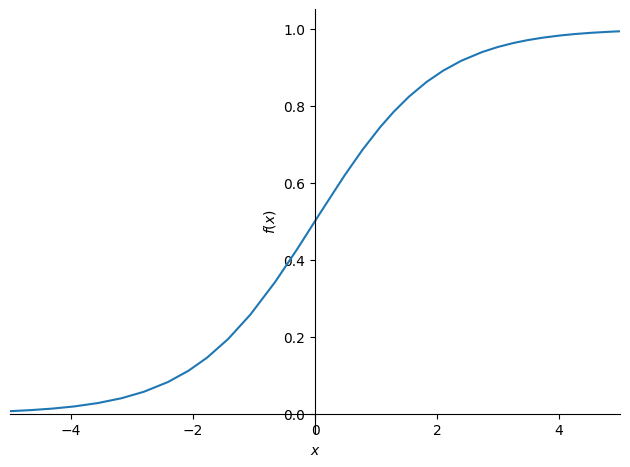

In [ ]:
import sympy
sympy.plot("1/(1+exp(-x))", xlim=(-5,5));

PyTorch already defines that function for us, so we can modify `calc_preds` to use it:

In [ ]:
def calc_preds(coeffs, indeps): 
  return torch.sigmoid((indeps*coeffs).sum(axis=1))

Let's train a new model now, using this updated function to calculate predictions:

In [ ]:
coeffs = train_model(epochs = 2000, lr=.2)

0.510; 0.508; 0.506; 0.504; 0.502; 0.500; 0.497; 0.495; 0.493; 0.491; 0.489; 0.487; 0.485; 0.483; 0.481; 0.479; 0.477; 0.474; 0.472; 0.470; 0.468; 0.466; 0.464; 0.462; 0.461; 0.459; 0.457; 0.455; 0.453; 0.451; 0.449; 0.447; 0.446; 0.444; 0.442; 0.440; 0.439; 0.437; 0.435; 0.434; 0.432; 0.430; 0.429; 0.427; 0.426; 0.424; 0.423; 0.421; 0.420; 0.418; 0.417; 0.415; 0.414; 0.413; 0.411; 0.410; 0.409; 0.407; 0.406; 0.405; 0.404; 0.402; 0.401; 0.400; 0.399; 0.398; 0.397; 0.396; 0.394; 0.393; 0.392; 0.391; 0.390; 0.389; 0.388; 0.387; 0.386; 0.385; 0.384; 0.383; 0.382; 0.382; 0.381; 0.380; 0.379; 0.378; 0.377; 0.376; 0.375; 0.375; 0.374; 0.373; 0.372; 0.371; 0.371; 0.370; 0.369; 0.368; 0.368; 0.367; 0.366; 0.365; 0.365; 0.364; 0.363; 0.363; 0.362; 0.361; 0.361; 0.360; 0.359; 0.359; 0.358; 0.357; 0.357; 0.356; 0.355; 0.355; 0.354; 0.354; 0.353; 0.352; 0.352; 0.351; 0.351; 0.350; 0.349; 0.349; 0.348; 0.348; 0.347; 0.347; 0.346; 0.346; 0.345; 0.344; 0.344; 0.343; 0.343; 0.342; 0.342; 0.341; 0.341;

The loss has improved by a lot. Let's check the accuracy:

In [ ]:
acc(coeffs)

tensor(0.7921)

That's improved too! Here's the coefficients of our trained model:

In [ ]:
show_coeffs()

{'Age': tensor(-0.7738),
 'SibSp': tensor(-0.1978),
 'Parch': tensor(0.1224),
 'LogFare': tensor(0.0839),
 'Sex_male': tensor(-3.5853),
 'Sex_female': tensor(2.7668),
 'Pclass_1': tensor(1.4180),
 'Pclass_2': tensor(0.9124),
 'Pclass_3': tensor(-1.4899),
 'Embarked_C': tensor(0.1729),
 'Embarked_Q': tensor(0.5246),
 'Embarked_S': tensor(-0.8044)}

Do these coefficients seem reasonable?

## Submitting to Kaggle

Now that we've got a trained model, we can prepare a submission to Kaggle. To do that, first we need to read the test set:

In [ ]:
tst_df = pd.read_csv(path/'test.csv')

In this case, it turns out that the test set is missing `Fare` for one passenger. We'll just fill it with `0` to avoid problems:

In [ ]:
tst_df['Fare'] = tst_df.Fare.fillna(0)

Now we can just copy the same steps we did to our training set and do the same exact things on our test set to preprocess the data:

In [ ]:
tst_df.fillna(modes, inplace=True)
tst_df['LogFare'] = np.log(tst_df['Fare']+1)
tst_df = pd.get_dummies(tst_df, columns=["Sex","Pclass","Embarked"])

tst_indep = tensor(tst_df[indep_cols].values, dtype=torch.float)
tst_indep = tst_indep / vals

Let's calculate our predictions of which passengers survived in the test set:

In [ ]:
tst_df['Survived'] = (calc_preds(tst_indep, coeffs)>0.5).int()

The sample submission on the Kaggle competition site shows that we're expected to upload a CSV with just `PassengerId` and `Survived`, so let's create that and save it:

In [ ]:
sub_df = tst_df[['PassengerId','Survived']]
sub_df.to_csv('sub.csv', index=False)

We can check the first few rows of the file to make sure it looks reasonable:

In [ ]:
!head sub.csv

PassengerId,Survived
892,0
893,1
894,0
895,0
896,1
897,0
898,1
899,0
900,1


When you click "save version" in Kaggle, and wait for the notebook to run, you'll see that `sub.csv` appears in the "Data" tab. Clicking on that file will show a *Submit* button, which allows you to submit to the competition.

## Using matrix product

We can make things quite a bit neater...

Take a look at the inner-most calculation we're doing to get the predictions:

In [ ]:
(val_indep*coeffs).sum(axis=1)

tensor([ 4.0065, -4.7536, -5.1061, -3.5935, -3.6837, -3.7894,  1.4675,  2.6394, -5.9201,  1.2558, -6.1597, -5.1013, -5.8891,  1.5987,
        -6.1814, -3.3625, -3.5559,  2.6977, -3.8103,  0.2032, -6.0824, -3.4689,  4.0396,  2.4829, -6.0450, -4.7642,  0.4921, -3.5269,
        -6.0136,  1.5985,  2.7770,  0.2870, -6.0340, -6.1450,  3.9484,  0.4418, -3.3786,  4.1827, -6.0821,  0.2354, -3.6283, -6.0821,
        -3.7453,  4.1066, -6.0435,  0.2278, -6.0766, -6.0442, -4.7549,  0.2881, -2.0572, -5.9975, -5.9780, -6.0934, -3.6960, -3.7540,
        -4.7536, -6.2148, -6.0531, -6.1171, -2.2395, -6.0407, -3.6994, -6.0533,  2.4688, -3.0959, -3.6740, -6.2135, -4.9042,  2.4755,
        -6.1017,  1.2960, -3.7444, -6.0801, -3.1596, -6.0052, -6.0821, -3.3034, -3.6257, -3.8947, -3.4665,  4.2209, -6.0727, -6.0834,
         2.4240, -2.6753, -2.1301,  3.3255,  3.5998, -3.6643, -6.1591, -6.0821,  4.1304, -5.1641,  1.4540, -2.8129, -3.8780,  1.5628,
         1.6179, -4.7069, -6.0287,  1.5985, -6.1598, -6.1404, 

Multiplying elements together and then adding across rows is identical to doing a matrix-vector product! Python uses the `@` operator to indicate matrix products, and is supported by PyTorch tensors. Therefore, we can replicate the above calculate more simply like so:

In [ ]:
val_indep@coeffs

tensor([ 4.0065, -4.7536, -5.1061, -3.5935, -3.6837, -3.7894,  1.4675,  2.6394, -5.9201,  1.2558, -6.1597, -5.1013, -5.8891,  1.5987,
        -6.1814, -3.3625, -3.5559,  2.6977, -3.8103,  0.2032, -6.0824, -3.4689,  4.0396,  2.4829, -6.0450, -4.7642,  0.4921, -3.5269,
        -6.0136,  1.5985,  2.7770,  0.2870, -6.0340, -6.1450,  3.9484,  0.4418, -3.3786,  4.1827, -6.0821,  0.2354, -3.6283, -6.0821,
        -3.7453,  4.1066, -6.0435,  0.2278, -6.0766, -6.0442, -4.7549,  0.2881, -2.0572, -5.9975, -5.9780, -6.0934, -3.6960, -3.7540,
        -4.7536, -6.2148, -6.0531, -6.1171, -2.2395, -6.0407, -3.6994, -6.0533,  2.4688, -3.0959, -3.6740, -6.2135, -4.9042,  2.4755,
        -6.1017,  1.2960, -3.7444, -6.0801, -3.1596, -6.0052, -6.0821, -3.3034, -3.6257, -3.8947, -3.4665,  4.2209, -6.0727, -6.0834,
         2.4240, -2.6753, -2.1301,  3.3255,  3.5998, -3.6643, -6.1591, -6.0821,  4.1304, -5.1641,  1.4540, -2.8129, -3.8780,  1.5628,
         1.6179, -4.7069, -6.0287,  1.5985, -6.1598, -6.1404, 

It also turns out that this is much faster, because matrix products in PyTorch are very highly optimised.

Let's use this to replace how `calc_preds` works:

In [ ]:
def calc_preds(coeffs, indeps): return torch.sigmoid(indeps@coeffs)

In order to do matrix-matrix products (which we'll need in the next section), we need to turn `coeffs` into a column vector (i.e. a matrix with a single column), which we can do by passing a second argument `1` to `torch.rand()`, indicating that we want our coefficients to have one column:

In [ ]:
def init_coeffs(): return (torch.rand(n_coeff, 1)*0.1).requires_grad_()

We'll also need to turn our dependent variable into a column vector, which we can do by indexing the column dimension with the special value `None`, which tells PyTorch to add a new dimension in this position:

In [ ]:
trn_dep = trn_dep[:,None]
val_dep = val_dep[:,None]

We can now train our model as before and confirm we get identical outputs...:

In [ ]:
coeffs = train_model(epochs = 2000, lr=.2)

0.512; 0.510; 0.508; 0.506; 0.504; 0.502; 0.499; 0.497; 0.495; 0.493; 0.491; 0.489; 0.486; 0.484; 0.482; 0.480; 0.478; 0.476; 0.474; 0.471; 0.469; 0.467; 0.465; 0.463; 0.461; 0.459; 0.457; 0.455; 0.453; 0.451; 0.449; 0.447; 0.445; 0.443; 0.441; 0.439; 0.438; 0.436; 0.434; 0.432; 0.430; 0.429; 0.427; 0.425; 0.424; 0.422; 0.420; 0.419; 0.417; 0.415; 0.414; 0.412; 0.411; 0.409; 0.408; 0.407; 0.405; 0.404; 0.402; 0.401; 0.400; 0.398; 0.397; 0.396; 0.395; 0.393; 0.392; 0.391; 0.390; 0.389; 0.387; 0.386; 0.385; 0.384; 0.383; 0.382; 0.381; 0.380; 0.379; 0.378; 0.377; 0.376; 0.375; 0.374; 0.373; 0.372; 0.371; 0.370; 0.369; 0.368; 0.368; 0.367; 0.366; 0.365; 0.364; 0.363; 0.363; 0.362; 0.361; 0.360; 0.359; 0.359; 0.358; 0.357; 0.356; 0.356; 0.355; 0.354; 0.354; 0.353; 0.352; 0.352; 0.351; 0.350; 0.350; 0.349; 0.348; 0.348; 0.347; 0.346; 0.346; 0.345; 0.345; 0.344; 0.343; 0.343; 0.342; 0.342; 0.341; 0.340; 0.340; 0.339; 0.339; 0.338; 0.338; 0.337; 0.337; 0.336; 0.336; 0.335; 0.335; 0.334; 0.334;

...and identical accuracy:

In [ ]:
acc(coeffs)

tensor(0.7921)

## A neural network

We've now got what we need to implement our neural network.

First, we'll need to create coefficients for each of our layers. Our first set of coefficients will take our `n_coeff` inputs, and create `n_hidden` outputs. We can choose whatever `n_hidden` we like -- a higher number gives our network more flexibility, but makes it slower and harder to train. So we need a matrix of size `n_coeff` by `n_hidden`. We'll divide these coefficients by `n_hidden` so that when we sum them up in the next layer we'll end up with similar magnitude numbers to what we started with.

Then our second layer will need to take the `n_hidden` inputs and create a single output, so that means we need a `n_hidden` by `1` matrix there. The second layer will also need a constant term added.

In [ ]:
def init_coeffs(n_hidden=20):
    layer1 = (torch.rand(n_coeff, n_hidden)-0.5)/n_hidden
    layer2 = torch.rand(n_hidden, 1)-0.3
    const = torch.rand(1)[0]
    return layer1.requires_grad_(),layer2.requires_grad_(),const.requires_grad_()

Now we have our coefficients, we can create our neural net. The key steps are the two matrix products, `indeps@l1` and `res@l2` (where `res` is the output of the first layer). The first layer output is passed to `F.relu` (that's our non-linearity), and the second is passed to `torch.sigmoid` as before.

In [ ]:
import torch.nn.functional as F

def calc_preds(coeffs, indeps):
    l1,l2,const = coeffs
    res = F.relu(indeps@l1)
    res = res@l2 + const
    return torch.sigmoid(res)

Finally, now that we have more than one set of coefficients, we need to add a loop to update each one:

In [ ]:
def update_coeffs(coeffs, lr):
    for layer in coeffs:
        layer.sub_(layer.grad * lr)
        layer.grad.zero_()

That's it -- we're now ready to train our model!

In [ ]:
coeffs = train_model(epochs = 2000, lr=1.4)

0.543; 0.532; 0.520; 0.505; 0.487; 0.466; 0.439; 0.407; 0.373; 0.343; 0.319; 0.301; 0.286; 0.274; 0.264; 0.256; 0.250; 0.245; 0.240; 0.237; 0.234; 0.231; 0.229; 0.227; 0.226; 0.224; 0.223; 0.222; 0.221; 0.220; 0.219; 0.218; 0.217; 0.217; 0.216; 0.215; 0.215; 0.214; 0.213; 0.213; 0.212; 0.212; 0.211; 0.210; 0.210; 0.210; 0.209; 0.209; 0.208; 0.208; 0.207; 0.207; 0.207; 0.206; 0.206; 0.205; 0.205; 0.205; 0.205; 0.204; 0.204; 0.204; 0.203; 0.203; 0.203; 0.203; 0.202; 0.202; 0.202; 0.202; 0.202; 0.201; 0.201; 0.201; 0.201; 0.201; 0.201; 0.200; 0.200; 0.200; 0.200; 0.200; 0.200; 0.200; 0.199; 0.199; 0.199; 0.199; 0.199; 0.199; 0.199; 0.199; 0.199; 0.198; 0.198; 0.198; 0.198; 0.198; 0.198; 0.198; 0.198; 0.198; 0.198; 0.198; 0.198; 0.197; 0.197; 0.197; 0.197; 0.197; 0.197; 0.197; 0.197; 0.197; 0.197; 0.197; 0.197; 0.197; 0.197; 0.197; 0.197; 0.197; 0.196; 0.196; 0.196; 0.196; 0.196; 0.196; 0.196; 0.196; 0.196; 0.196; 0.196; 0.196; 0.196; 0.196; 0.196; 0.196; 0.196; 0.196; 0.196; 0.196; 0.196;

In [ ]:
coeffs = train_model(lr=20)

0.543; 0.400; 0.260; 0.390; 0.221; 0.211; 0.197; 0.195; 0.193; 0.193; 0.193; 0.193; 0.193; 0.193; 0.193; 0.193; 0.193; 0.192; 0.192; 0.192; 0.192; 0.192; 0.192; 0.192; 0.192; 0.192; 0.192; 0.192; 0.192; 0.192; 

It's looking good -- our loss is lower than before. Let's see if that translates to a better result on the validation set:

In [ ]:
acc(coeffs)

tensor(0.8258)

In this case our neural net isn't showing better results than the linear model. That's not surprising; this dataset is very small and very simple, and isn't the kind of thing we'd expect to see neural networks excel at. Furthermore, our validation set is too small to reliably see much accuracy difference. But the key thing is that we now know exactly what a real neural net looks like!

## Deep learning

The neural net in the previous section only uses one hidden layer, so it doesn't count as "deep" learning. But we can use the exact same technique to make our neural net deep, by adding more matrix multiplications.

First, we'll need to create additional coefficients for each layer:

In [ ]:
def init_coeffs():
    hiddens = [10, 10]  # <-- set this to the size of each hidden layer you want
    sizes = [n_coeff] + hiddens + [1]
    n = len(sizes)
    layers = [(torch.rand(sizes[i], sizes[i+1])-0.3)/sizes[i+1]*4 for i in range(n-1)]
    consts = [(torch.rand(1)[0]-0.5)*0.1 for i in range(n-1)]
    for l in layers+consts: l.requires_grad_()
    return layers,consts

You'll notice here that there's a lot of messy constants to get the random numbers in just the right ranges. When you train the model in a moment, you'll see that the tiniest changes to these initialisations can cause our model to fail to train at all! This is a key reason that deep learning failed to make much progress in the early days -- it's very finicky to get a good starting point for our coefficients. Nowadays, we have ways to deal with that, which we'll learn about in other notebooks.

Our deep learning `calc_preds` looks much the same as before, but now we loop through each layer, instead of listing them separately:

In [ ]:
import torch.nn.functional as F

def calc_preds(coeffs, indeps):
    layers,consts = coeffs
    n = len(layers)
    res = indeps
    for i,l in enumerate(layers):
        res = res@l + consts[i]
        if i!=n-1: res = F.relu(res)
    return torch.sigmoid(res)

We also need a minor update to `update_coeffs` since we've got `layers` and `consts` separated now:

In [ ]:
def update_coeffs(coeffs, lr):
    layers,consts = coeffs
    for layer in layers+consts:
        layer.sub_(layer.grad * lr)
        layer.grad.zero_()

Let's train our model...

In [ ]:
coeffs = train_model(epochs = 2000, lr=.5)

0.521; 0.470; 0.436; 0.403; 0.372; 0.348; 0.328; 0.308; 0.290; 0.274; 0.261; 0.252; 0.245; 0.240; 0.235; 0.232; 0.229; 0.227; 0.225; 0.224; 0.222; 0.221; 0.220; 0.219; 0.218; 0.218; 0.217; 0.216; 0.215; 0.214; 0.214; 0.213; 0.212; 0.212; 0.211; 0.210; 0.210; 0.209; 0.208; 0.208; 0.207; 0.207; 0.206; 0.206; 0.205; 0.205; 0.205; 0.204; 0.204; 0.203; 0.203; 0.203; 0.202; 0.202; 0.202; 0.202; 0.201; 0.201; 0.201; 0.201; 0.200; 0.200; 0.200; 0.200; 0.200; 0.199; 0.199; 0.199; 0.199; 0.199; 0.199; 0.198; 0.198; 0.198; 0.198; 0.198; 0.198; 0.198; 0.198; 0.197; 0.197; 0.197; 0.197; 0.197; 0.197; 0.197; 0.197; 0.197; 0.197; 0.197; 0.196; 0.196; 0.196; 0.196; 0.196; 0.196; 0.196; 0.196; 0.196; 0.196; 0.196; 0.196; 0.196; 0.196; 0.196; 0.196; 0.195; 0.195; 0.195; 0.195; 0.195; 0.195; 0.195; 0.195; 0.195; 0.195; 0.195; 0.195; 0.195; 0.195; 0.195; 0.195; 0.195; 0.195; 0.195; 0.195; 0.195; 0.195; 0.195; 0.195; 0.195; 0.195; 0.195; 0.195; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194;

...and check its accuracy:

In [ ]:
acc(coeffs)

tensor(0.8258)

## Final thoughts

It's actually pretty cool that we've managed to create a real deep learning model from scratch and trained it to get over 80% accuracy on this task, all in the course of a single notebook!

The "real" deep learning models that are used in research and industry look very similar to this, and in fact if you look inside the source code of any deep learning model you'll recognise the basic steps are the same.

The biggest differences in practical models to what we have above are:

- How initialisation and normalisation is done to ensure the model trains correctly every time
- Regularization (to avoid over-fitting)
- Modifying the neural net itself to take advantage of knowledge of the problem domain
- Doing gradient descent steps on smaller batches, rather than the whole dataset.

Citations: Jeremy Howard, Kaggle, Titanic Competition